In [2]:
import os
import sys
import random
import numpy as np
import pandas as pd
import cv2


In [3]:
import numpy as np
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Import necessary items from Keras
from keras.models import Sequential
from keras.layers import Activation, Dropout, UpSampling2D
from keras.layers import Conv2DTranspose, Conv2D, MaxPooling2D
#from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [4]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Activation,AveragePooling2D ,BatchNormalization,ReLU ,Add,Dense,Reshape,Multiply, Dropout, UpSampling2D,Conv2D,MaxPooling2D,concatenate,add,GlobalAveragePooling2D,GlobalMaxPool2D,Multiply

In [6]:
train_images =np.load("D:/projects/Lane_deep/Dataset/image_mixed.npy").astype(np.float32)
labels = np.load("D:/projects/Lane_deep/Dataset/label_mixed.npy").astype(np.float32)
train_images = np.array(train_images)
labels = np.array(labels)
labels = labels / 255
train_images, labels = shuffle(train_images, labels)
X_train, X_val, y_train, y_val = train_test_split(train_images, labels, test_size=0.3)
batch_size =64
epochs = 100
pool_size = (2, 2)
input_shape = X_train.shape[1:]

In [7]:
import tensorflow.keras.backend as K

def dsc(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def dice_loss(y_true, y_pred):
    return 1.0 - dsc(y_true, y_pred)



def IOU(y_true, y_pred):

    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)

    thresh = 0.5

    y_true = K.cast(K.greater_equal(y_true, thresh), 'float32')
    y_pred = K.cast(K.greater_equal(y_pred, thresh), 'float32')

    union = K.sum(K.maximum(y_true, y_pred)) + K.epsilon()
    intersection = K.sum(K.minimum(y_true, y_pred)) + K.epsilon()

    iou = intersection/union

    return iou

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [8]:
def FCN():
    
    inputs =keras.layers.Input((80,160,3))
    c1 = Conv2D(16, (3,3), padding="same")(inputs)
    b1 = BatchNormalization()(c1)
    a1 = Activation("relu")(b1)
    p1=MaxPooling2D(pool_size=(2,2))(a1)
    
    c2 = Conv2D(32, (3,3), padding="same")(p1)
    b2 = BatchNormalization()(c2)
    a2 = Activation("relu")(b2)
    p2=MaxPooling2D(pool_size=(2,2))(a2)
    
    
    c3 = Conv2D(64, (3,3), padding="same")(p2)
    b3 = BatchNormalization()(c3)
    a3 = Activation("relu")(b3)
    p3=MaxPooling2D(pool_size=(2,2))(a3)
    
    
    
    c4 = Conv2D(128, (3,3), padding="same")(p3)
    b4 = BatchNormalization()(c4)
    a4 = Activation("relu")(b4)
    p4=MaxPooling2D(pool_size=(2,2))(a4)
    
    
    
    c5 = Conv2D(256,(3,3), padding="same")(p4)
    b5 = BatchNormalization()(c5)
    a5 = Activation("relu")(b5)
    #p5=MaxPooling2D(pool_size=(2,2))(a5)
    
    
    
    u1=UpSampling2D(size=(2, 2))(a5)
    d1 = Conv2D(256, (3,3), padding="same")(u1)
    b6 = BatchNormalization()(d1)
    a6= Activation("relu")(b6)
    
    
    u2=UpSampling2D(size=(2, 2))(a6)
    d2 = Conv2D(128, (3,3), padding="same")(u2)
    b7 = BatchNormalization()(d2)
    a7= Activation("relu")(b7)
    
    
    u3=UpSampling2D(size=(2, 2))(a7)
    d3 = Conv2D(64, (3,3), padding="same")(u3)
    b8 = BatchNormalization()(d3)
    a8 = Activation("relu")(b8)
    
    u4=UpSampling2D(size=(2, 2))(a8)
    d4 = Conv2D(32, (3,3), padding="same")(u4)
    b9 = BatchNormalization()(d4)
    a9 = Activation("relu")(b9)
    
    
    #u5=UpSampling2D(size=(2, 2))(a9)
    d5= Conv2D(16, (3,3), padding="same")(a9)
    b10 = BatchNormalization()(d5)
    a10 = Activation("relu")(b10)
    
    
    outputs = Conv2D(1, (1,1), padding="same", activation="sigmoid")(a10)

    model = tf.keras.Model(inputs, outputs, name="FCN")
    
    
    
    

    
    return model

In [10]:
model =FCN()
datagen = ImageDataGenerator(channel_shift_range=0.2)
datagen.fit(X_train)
opt = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=opt,  loss = dice_loss, metrics = ['dsc','accuracy', 'IOU','precision_m', 'recall_m', 'f1_m'])
model.summary()

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 160, 3)]      0         
                                                                 
 conv2d (Conv2D)             (None, 80, 160, 16)       448       
                                                                 
 batch_normalization (BatchN  (None, 80, 160, 16)      64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 80, 160, 16)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 40, 80, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 80, 32)        4640    

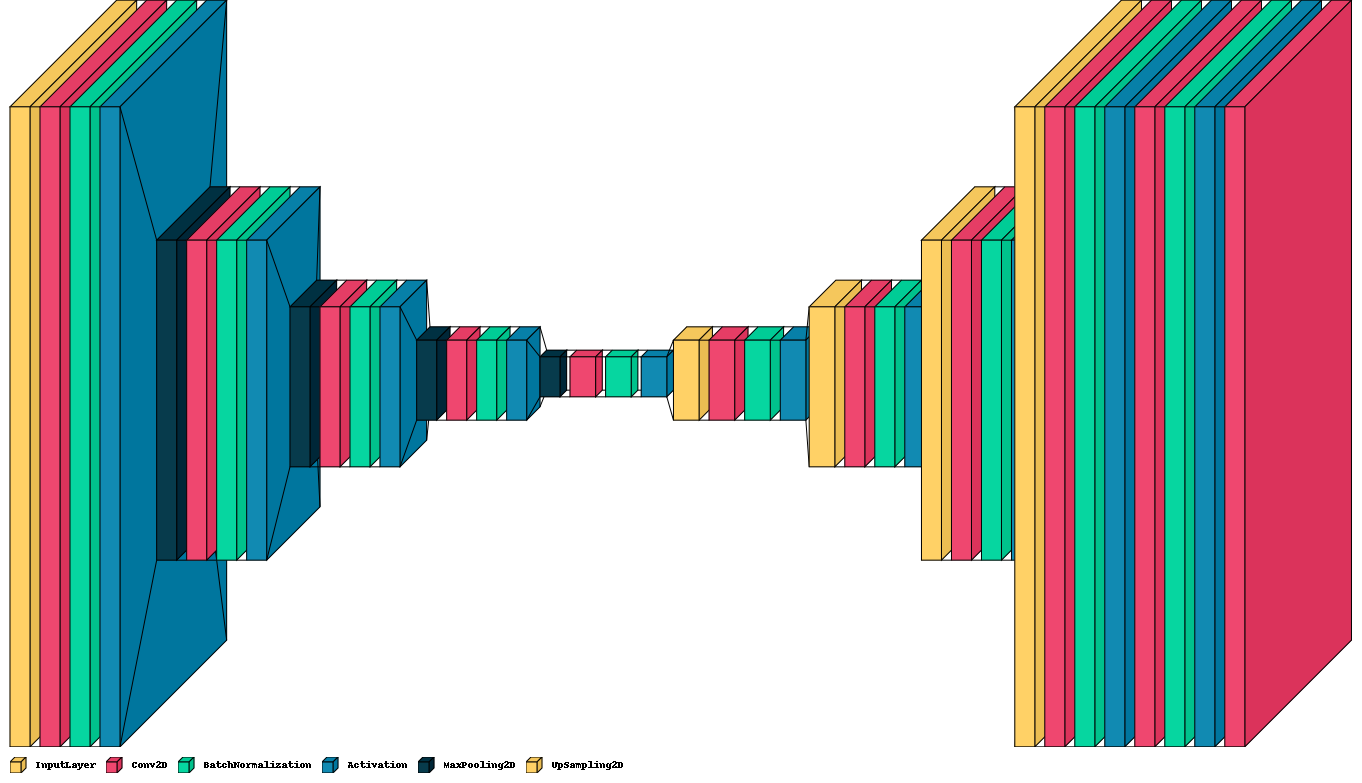

In [10]:
from PIL import ImageFont
visualkeras.layered_view(model, legend=True) 

In [11]:
model.save('D:/projects/lane_FCN.h5')

In [12]:
from tensorflow.keras.models import load_model
 
# load model
model = load_model('D:/projects/Lane_FCN.h5',custom_objects={'dice_loss':dice_loss,'IOU':IOU,'dsc':dsc,'precision_m':precision_m, 'recall_m':recall_m, 'f1_m':f1_m})
# summarize model.

In [13]:
history=model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), steps_per_epoch=len(X_train)/batch_size,
epochs=epochs, verbose=1, validation_data=(X_val, y_val))

model.save('D:/projects/Lane_FCN.h5')

C:\Users\USER\AppData\Local\Temp/ipykernel_14996/2442308158.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), steps_per_epoch=len(X_train)/batch_size,


Epoch 1/100
164/164 [==============================] - 14s 64ms/step - loss: 0.4079 - dsc: 0.5917 - accuracy: 0.8897 - IOU: 0.7637 - precision_m: 0.7683 - recall_m: 0.9804 - f1_m: 0.8513 - val_loss: 0.4194 - val_dsc: 0.5806 - val_accuracy: 0.9404 - val_IOU: 0.8593 - val_precision_m: 0.8662 - val_recall_m: 0.9750 - val_f1_m: 0.9173
Epoch 2/100
164/164 [==============================] - 9s 56ms/step - loss: 0.3546 - dsc: 0.6450 - accuracy: 0.9474 - IOU: 0.8862 - precision_m: 0.8907 - recall_m: 0.9855 - f1_m: 0.9356 - val_loss: 0.3581 - val_dsc: 0.6419 - val_accuracy: 0.9499 - val_IOU: 0.8970 - val_precision_m: 0.9004 - val_recall_m: 0.9862 - val_f1_m: 0.9413
Epoch 3/100
164/164 [==============================] - 9s 56ms/step - loss: 0.3277 - dsc: 0.6730 - accuracy: 0.9519 - IOU: 0.9071 - precision_m: 0.9116 - recall_m: 0.9866 - f1_m: 0.9475 - val_loss: 0.3245 - val_dsc: 0.6755 - val_accuracy: 0.9481 - val_IOU: 0.8890 - val_precision_m: 0.8912 - val_recall_m: 0.9917 - val_f1_m: 0.9387
Epo

Epoch 26/100
164/164 [==============================] - 9s 56ms/step - loss: 0.0345 - dsc: 0.9655 - accuracy: 0.9636 - IOU: 0.9773 - precision_m: 0.9852 - recall_m: 0.9889 - f1_m: 0.9870 - val_loss: 0.0367 - val_dsc: 0.9633 - val_accuracy: 0.9628 - val_IOU: 0.9702 - val_precision_m: 0.9818 - val_recall_m: 0.9852 - val_f1_m: 0.9835
Epoch 27/100
164/164 [==============================] - 9s 56ms/step - loss: 0.0324 - dsc: 0.9677 - accuracy: 0.9636 - IOU: 0.9780 - precision_m: 0.9858 - recall_m: 0.9891 - f1_m: 0.9874 - val_loss: 0.0353 - val_dsc: 0.9647 - val_accuracy: 0.9627 - val_IOU: 0.9692 - val_precision_m: 0.9781 - val_recall_m: 0.9883 - val_f1_m: 0.9832
Epoch 28/100
164/164 [==============================] - 9s 56ms/step - loss: 0.0312 - dsc: 0.9688 - accuracy: 0.9636 - IOU: 0.9769 - precision_m: 0.9854 - recall_m: 0.9885 - f1_m: 0.9869 - val_loss: 0.0334 - val_dsc: 0.9666 - val_accuracy: 0.9628 - val_IOU: 0.9696 - val_precision_m: 0.9835 - val_recall_m: 0.9831 - val_f1_m: 0.9833
E

Epoch 51/100
164/164 [==============================] - 9s 56ms/step - loss: 0.0153 - dsc: 0.9847 - accuracy: 0.9641 - IOU: 0.9838 - precision_m: 0.9904 - recall_m: 0.9914 - f1_m: 0.9909 - val_loss: 0.0198 - val_dsc: 0.9802 - val_accuracy: 0.9631 - val_IOU: 0.9730 - val_precision_m: 0.9851 - val_recall_m: 0.9860 - val_f1_m: 0.9856
Epoch 52/100
164/164 [==============================] - 9s 56ms/step - loss: 0.0150 - dsc: 0.9850 - accuracy: 0.9642 - IOU: 0.9843 - precision_m: 0.9906 - recall_m: 0.9917 - f1_m: 0.9912 - val_loss: 0.0198 - val_dsc: 0.9802 - val_accuracy: 0.9631 - val_IOU: 0.9728 - val_precision_m: 0.9869 - val_recall_m: 0.9840 - val_f1_m: 0.9854
Epoch 53/100
164/164 [==============================] - 9s 56ms/step - loss: 0.0154 - dsc: 0.9846 - accuracy: 0.9641 - IOU: 0.9829 - precision_m: 0.9900 - recall_m: 0.9910 - f1_m: 0.9905 - val_loss: 0.0196 - val_dsc: 0.9804 - val_accuracy: 0.9631 - val_IOU: 0.9729 - val_precision_m: 0.9847 - val_recall_m: 0.9864 - val_f1_m: 0.9855
E

Epoch 76/100
164/164 [==============================] - 9s 56ms/step - loss: 0.0125 - dsc: 0.9875 - accuracy: 0.9644 - IOU: 0.9874 - precision_m: 0.9927 - recall_m: 0.9932 - f1_m: 0.9929 - val_loss: 0.0183 - val_dsc: 0.9817 - val_accuracy: 0.9631 - val_IOU: 0.9734 - val_precision_m: 0.9873 - val_recall_m: 0.9847 - val_f1_m: 0.9860
Epoch 77/100
164/164 [==============================] - 9s 56ms/step - loss: 0.0125 - dsc: 0.9874 - accuracy: 0.9644 - IOU: 0.9873 - precision_m: 0.9925 - recall_m: 0.9933 - f1_m: 0.9929 - val_loss: 0.0183 - val_dsc: 0.9817 - val_accuracy: 0.9631 - val_IOU: 0.9735 - val_precision_m: 0.9851 - val_recall_m: 0.9872 - val_f1_m: 0.9861
Epoch 78/100
164/164 [==============================] - 9s 56ms/step - loss: 0.0124 - dsc: 0.9876 - accuracy: 0.9644 - IOU: 0.9879 - precision_m: 0.9929 - recall_m: 0.9934 - f1_m: 0.9932 - val_loss: 0.0181 - val_dsc: 0.9819 - val_accuracy: 0.9632 - val_IOU: 0.9741 - val_precision_m: 0.9878 - val_recall_m: 0.9849 - val_f1_m: 0.9863
E

In [14]:
train_loss = history.history['loss']
valid_loss = history.history['val_loss']

train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']

In [15]:
from numpy import savetxt
savetxt('train_loss.csv', train_loss, delimiter=',')
savetxt('valid_loss.csv', valid_loss, delimiter=',')

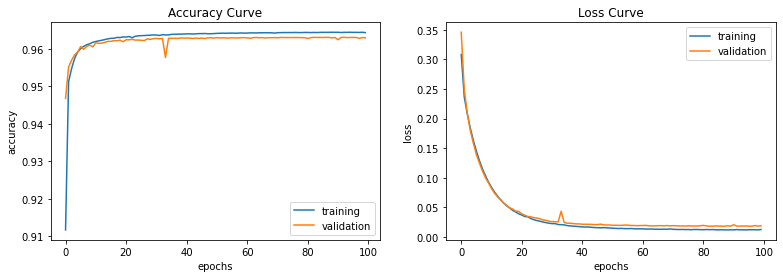

In [16]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(13,4))
axes = axes.flatten()

axes[0].plot(train_acc, label='training')
axes[0].plot(valid_acc, label='validation')
axes[0].set_title('Accuracy Curve')
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('accuracy')
axes[0].legend()


axes[1].plot(train_loss, label='training')
axes[1].plot(valid_loss, label='validation')
axes[1].set_title('Loss Curve')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('loss')
axes[1].legend()

plt.show()

In [17]:
train_dice = history.history['dsc']
valid_dice = history.history['val_dsc']


train_IOU = history.history['IOU']
valid_IOU = history.history['val_IOU']

In [ ]:
from numpy import savetxt
savetxt('train_dice.csv', train_dice, delimiter=',')
savetxt('valid_dice.csv', valid_dice, delimiter=',')

savetxt('train_IOU.csv', train_IOU, delimiter=',')
savetxt('valid_IOU.csv', valid_IOU, delimiter=',')

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20,7))
axes = axes.flatten()

axes[0].plot(train_IOU, label='training')
axes[0].plot(valid_IOU, label='validation')
axes[0].set_title('IOU Curve ')
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('IOU')
axes[0].legend()


axes[1].plot(train_dice, label='training')
axes[1].plot(valid_dice, label='validation')
axes[1].set_title('Dice coefficient Curve')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('dice_coef')
axes[1].legend()

plt.show()